In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from IPython.display import HTML, display
import scipy.stats as st

# <center><b>WebScrapping from kolesa.kz</b></center>

In [2]:
driver = webdriver.Chrome()  

In [3]:
city = 'astana'
car_company = 'toyota'
car_model = 'camry'
start_year = 2019

In [4]:
url = f'https://kolesa.kz/cars/{car_company}/{car_model}/{city}/?year%5Bfrom%5D={start_year}'

In [5]:
driver.get(url)

In [6]:
time.sleep(5)

In [7]:
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'a-card__info')))

<selenium.webdriver.remote.webelement.WebElement (session="05c7823d1b77bfe13b1d1b654dc35718", element="f.422BE15B1DD0D50081DCE8D191AE4E07.d.1A2AE9676D83E34E1EF567EEB75930E4.e.157")>

In [8]:
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [9]:
car_listings = soup.find_all('div', class_='a-card')

In [10]:
driver.get(url)
soup = BeautifulSoup(driver.page_source, 'html.parser')

pagination_links = soup.select('a[href*="page="]')
pages = []
for link in pagination_links:
    text = link.get_text(strip=True)
    try:
        pages.append(int(text))
    except ValueError:
        continue

max_page = max(pages) if pages else 1
print("max page:", max_page)

max page: 23


In [11]:
cars = []

for page in range(1, max_page):  
    url = f'https://kolesa.kz/cars/{car_company}/{car_model}/{city}/?year%5Bfrom%5D={start_year}&page={page}'
    driver.get(url)

    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, 'a-card__link'))
    )

    soup = BeautifulSoup(driver.page_source, 'html.parser')

    listings = soup.find_all('div', class_='a-list__item')

    for item in listings:
        
        header = item.find('div', class_='a-card__header')
        if header:
            title_elem = header.find('h5', class_='a-card__title')
            if title_elem:
                link_elem = title_elem.find('a', class_='a-card__link')
        price_elem = item.find('span', class_='a-card__price')
        desc_elem = item.find('p', class_='a-card__description')

        if title_elem and price_elem and desc_elem:
            title = title_elem.text.strip()
            price = price_elem.text.strip().replace('\xa0', ' ')
            description = desc_elem.text.strip()
            link = 'https://kolesa.kz' + link_elem['href'] if link_elem and link_elem.has_attr('href') else None


            cars.append({
                'Title': title,
                'Price': price,
                'Description': description,
                'URL': link
            })

    time.sleep(2)

# <center><b>Explaratory Data Analysis</b></center>

In [12]:
df = pd.DataFrame(cars)

df['Year'] = df['Description'].str.extract(r'(\d{4}) г\.')
df['Condition'] = df['Description'].str.extract(r'(Б/у|новый)')
df['Car Type'] = df['Description'].str.extract(r'(седан|внедорожник|купе|хэтчбек|универсал|кроссовер)')
df['Engine Size (L)'] = df['Description'].str.extract(r'(\d\.\d) л')
df['Fuel Type'] = df['Description'].str.extract(r'(бензин|дизель|газ|гибрид|электро)')
df['Transmission'] = df['Description'].str.extract(r'(КПП автомат|КПП механика|КПП вариатор|АКПП|МКПП)')
df['Mileage (km)'] = df['Description'].str.extract(r'с пробегом ([\d\s]+) км')

df['Condition'] = df['Condition'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Car Type'] = df['Car Type'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Fuel Type'] = df['Fuel Type'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Transmission'] = df['Transmission'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Mileage (km)'] = df['Mileage (km)'].str.replace(' ', '').fillna('0').astype(int)

df.drop('Description', axis=1, inplace=True) #becomes useless

condition_mapping = {
    "Б/у": "Used",
    "новый": "New"
}

car_type_mapping = {
    "седан": "Sedan",
    "внедорожник": "SUV",
    "купе": "Coupe",
    "хэтчбек": "Hatchback",
    "универсал": "Station Wagon",
    "кроссовер": "Crossover"
}

fuel_mapping = {
    "бензин": "Gasoline",
    "дизель": "Diesel",
    "газ": "Gas",
    "гибрид": "Hybrid",
    "электро": "Electric"
}

transmission_mapping = {
    "КПП автомат": "Automatic",
    "КПП механика": "Manual",
    "КПП вариатор": "CVT",
    "АКПП": "Automatic",
    "МКПП": "Manual"
}

Applying mapping:

In [13]:
df['Condition'] = df['Condition'].map(condition_mapping)
df['Car Type'] = df['Car Type'].map(car_type_mapping)
df['Fuel Type'] = df['Fuel Type'].map(fuel_mapping)
df['Transmission'] = df['Transmission'].map(transmission_mapping)

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Engine Size (L)'] = pd.to_numeric(df['Engine Size (L)'], errors='coerce')

df

,Title,Price,URL,Year,Condition,Car Type,Engine Size (L),Fuel Type,Transmission,Mileage (km)
0,Toyota Camry,12 450 000 ₸,https://kolesa.kz/a/show/185379443?search_id=f...,2020,Used,Sedan,2.5,Gasoline,Automatic,171222
1,Toyota Camry,16 610 000 ₸,https://kolesa.kz/a/show/183415548?search_id=f...,2023,Used,Sedan,2.5,Gasoline,Automatic,19889
2,Toyota Camry,13 730 000 ₸,https://kolesa.kz/a/show/182103237?search_id=f...,2021,Used,Sedan,2.5,Gasoline,Automatic,123965
3,Toyota Camry,14 440 000 ₸,https://kolesa.kz/a/show/181811722?search_id=f...,2021,Used,Sedan,2.5,Gasoline,Automatic,47379
4,Toyota Camry,14 180 000 ₸,https://kolesa.kz/a/show/182915337?search_id=f...,2021,Used,Sedan,2.5,Gasoline,Automatic,83082
...,...,...,...,...,...,...,...,...,...,...
435,Toyota Camry,13 500 000 ₸,https://kolesa.kz/a/show/184859206?search_id=2...,2019,Used,Sedan,2.5,Gasoline,Automatic,150000
436,Toyota Camry,21 000 000 ₸,https://kolesa.kz/a/show/183270718?search_id=2...,2024,Used,Sedan,2.5,Gasoline,Automatic,0
437,Toyota Camry,15 250 000 ₸,https://kolesa.kz/a/show/184853775?search_id=2...,2019,Used,Sedan,2.5,Gasoline,Automatic,96000
438,Toyota Camry,14 000 000 ₸,https://kolesa.kz/a/show/184853688?search_id=2...,2020,Used,Sedan,2.5,Gasoline,Automatic,181


In [14]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce', downcast='integer')
df['Price'] = df['Price'].str.replace(r'\D+', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce', downcast='integer')
df['Engine Size (L)'] = pd.to_numeric(df['Engine Size (L)'], errors='coerce')
df['Mileage (km)'] = pd.to_numeric(df['Mileage (km)'], errors='coerce', downcast='integer')
df['Engine Size (L)'] = df['Engine Size (L)'].astype('category')

In [15]:
df.columns

Index(['Title', 'Price', 'URL', 'Year', 'Condition', 'Car Type',
       'Engine Size (L)', 'Fuel Type', 'Transmission', 'Mileage (km)'],
      dtype='object')

In [16]:
df.dtypes

Title                object
Price                 int32
URL                  object
Year                  int16
Condition            object
Car Type             object
Engine Size (L)    category
Fuel Type            object
Transmission         object
Mileage (km)          int32
dtype: object

In [17]:
print(df.isnull().sum()) #missing values per column

Title               0
Price               0
URL                 0
Year                0
Condition           0
Car Type            0
Engine Size (L)    37
Fuel Type           0
Transmission        0
Mileage (km)        0
dtype: int64


#### Extracting engine size from the Title (if "2.5" or "3.5" is mentioned)

In [18]:
def impute_engine_from_title(row):
    if pd.isna(row['Engine Size (L)']):
        title = row['Title'].lower()
        if '2.5' in title:
            return 2.5
        elif '3.5' in title:
            return 3.5
    return row['Engine Size (L)']

df['Engine Size (L)'] = df.apply(impute_engine_from_title, axis=1)


In [19]:
mode_engine = df['Engine Size (L)'].mode()[0]
df['Engine Size (L)'] = df['Engine Size (L)'].fillna(mode_engine)


In [20]:
print(df.isnull().sum()) #missing values per column

Title              0
Price              0
URL                0
Year               0
Condition          0
Car Type           0
Engine Size (L)    0
Fuel Type          0
Transmission       0
Mileage (km)       0
dtype: int64


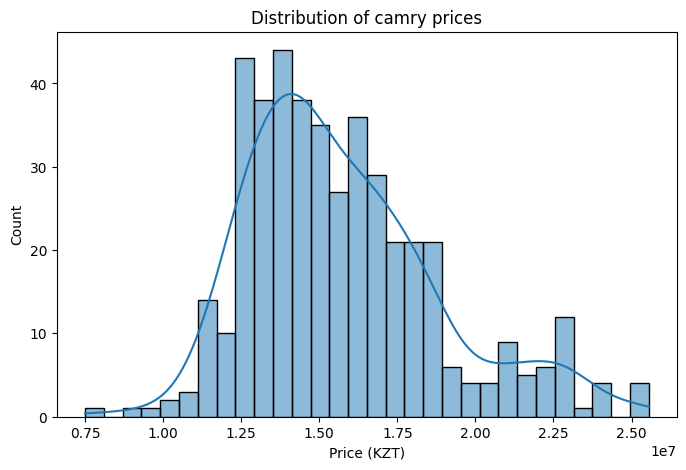

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title(f'Distribution of {car_model} prices')
plt.xlabel('Price (KZT)')
plt.ylabel('Count')

plt.show()

/var/folders/sc/t9x4mmz94hzfzv_kms3s9n440000gn/T/ipykernel_83133/3253823361.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Condition', y='Price', estimator='mean', palette='Paired')


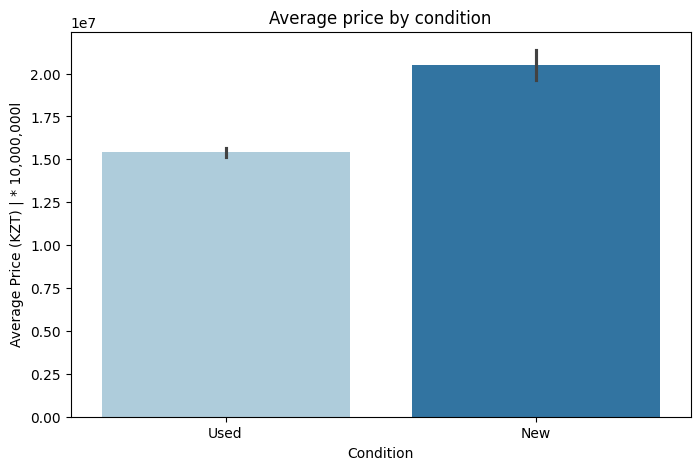

In [22]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Condition', y='Price', estimator='mean', palette='Paired')
plt.title('Average price by condition')
plt.xlabel('Condition')
plt.ylabel('Average Price (KZT) | * 10,000,000l')
plt.show()


In [23]:
print(df.shape)
print(df[['Mileage (km)', 'Price']].dropna().shape)

(440, 10)
(440, 2)


In [24]:
print(df['Mileage (km)'].isna().sum())
print(df['Price'].isna().sum())

0
0


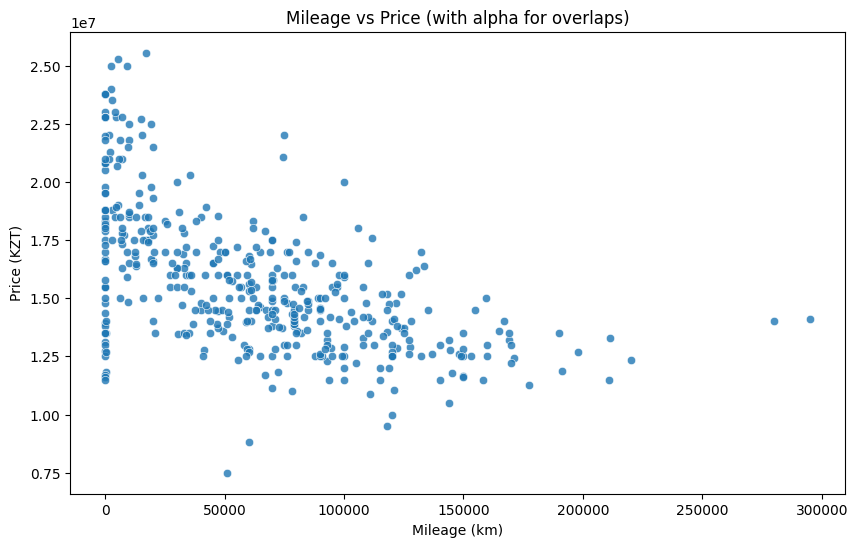

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Mileage (km)', y='Price', alpha=0.8)
plt.title('Mileage vs Price (with alpha for overlaps)')
plt.xlabel('Mileage (km)')
plt.ylabel('Price (KZT)')
plt.show()


In [26]:
df_model = df[['Price', 'Mileage (km)', 'Year', 'Engine Size (L)']].dropna()

# 2. Признаки (X) и целевая переменная (y)
X = df_model[['Mileage (km)', 'Year', 'Engine Size (L)']]
y = df_model['Price']

# 3. Обучим модель
model = LinearRegression()
model.fit(X, y)

# 4. Сделаем прогнозы и посчитаем остатки
df_model['Predicted Price'] = model.predict(X)
df_model['Residual'] = df_model['Price'] - df_model['Predicted Price']


In [27]:
coeffs = pd.DataFrame({
    'Feature': ['Intercept'] + list(X.columns),
    'Coefficient': [model.intercept_] + list(model.coef_)
})
print(coeffs)


           Feature   Coefficient
0        Intercept -2.221072e+09
1     Mileage (km) -1.054631e+01
2             Year  1.103601e+06
3  Engine Size (L)  2.703936e+06


In [28]:

overpriced = df_model.sort_values(by='Residual', ascending=False).head(10)
underpriced = df_model.sort_values(by='Residual', ascending=True).head(10)


print(f"underrated {car_company} {car_model}:")
display(underpriced)

print(f"overrated {car_company} {car_model}:")
display(overpriced)

underrated toyota camry:


,Price,Mileage (km),Year,Engine Size (L),Predicted Price,Residual
420,7500000,51000,2021,2.5,1.552835e+07,-8.028351e+06
157,14000000,20000,2024,3.5,2.187003e+07,-7.870027e+06
71,8800000,60345,2020,2.5,1.432619e+07,-5.526194e+06
301,11000000,78000,2022,2.5,1.634720e+07,-5.347202e+06
229,11600000,0,2021,2.5,1.606621e+07,-4.466213e+06
171,9500000,118000,2020,2.5,1.371815e+07,-4.218147e+06
50,11160000,70021,2021,2.5,1.532775e+07,-4.167750e+06
133,12000000,115000,2022,2.5,1.595699e+07,-3.956989e+06
53,12790000,41300,2022,2.5,1.673425e+07,-3.944252e+06
57,11060000,120966,2021,2.5,1.479047e+07,-3.730468e+06


overrated toyota camry:


,Price,Mileage (km),Year,Engine Size (L),Predicted Price,Residual
197,25550000,17000,2024,2.5,1.919773e+07,6.352270e+06
345,25300000,5500,2024,2.5,1.931901e+07,5.980987e+06
307,25000000,2500,2024,2.5,1.935065e+07,5.649348e+06
156,20000000,100000,2021,2.5,1.501158e+07,4.988418e+06
153,21068000,74437,2022,2.5,1.638478e+07,4.683221e+06
185,24000000,2600,2024,2.5,1.934960e+07,4.650403e+06
191,25000000,9000,2025,2.5,2.038570e+07,4.614298e+06
332,20293200,35654,2021,2.5,1.569019e+07,4.603005e+06
20,23790000,0,2024,2.5,1.937702e+07,4.412983e+06
237,23790000,0,2024,2.5,1.937702e+07,4.412983e+06


In [ ]:
df_model = df[['Title', 'URL', 'Price', 'Mileage (km)', 'Year', 'Engine Size (L)']].dropna()

X = df_model[['Mileage (km)', 'Year', 'Engine Size (L)']]
y = df_model['Price']

model = LinearRegression()
model.fit(X, y)

df_model['Predicted Price'] = model.predict(X)
df_model['Residual'] = df_model['Predicted Price'] - df_model['Price']


In [ ]:
def make_clickable(link):
    return f'<a href="{link}" target="_blank">Link</a>'


In [ ]:
top_underpriced = df_model[df_model['Residual'] > 1_000_000].sort_values(by='Residual', ascending=False).head(10)
df_display = top_underpriced[['Title', 'Price', 'Predicted Price', 'Residual', 'URL']].copy()
df_display['URL'] = df_display['URL'].apply(make_clickable)
display(HTML(df_display.to_html(escape=False, index=False)))


Title,Price,Predicted Price,Residual,URL
Toyota Camry,7500000,1.552835e+07,8.028351e+06,🔗 Link
Toyota Camry,14000000,2.187003e+07,7.870027e+06,🔗 Link
Toyota Camry,8800000,1.432619e+07,5.526194e+06,🔗 Link
Toyota Camry,11000000,1.634720e+07,5.347202e+06,🔗 Link
Toyota Camry,11600000,1.606621e+07,4.466213e+06,🔗 Link
Toyota Camry,9500000,1.371815e+07,4.218147e+06,🔗 Link
Toyota Camry,11160000,1.532775e+07,4.167750e+06,🔗 Link
Toyota Camry,12000000,1.595699e+07,3.956989e+06,🔗 Link
Toyota Camry,12790000,1.673425e+07,3.944252e+06,🔗 Link
Toyota Camry,11060000,1.479047e+07,3.730468e+06,🔗 Link


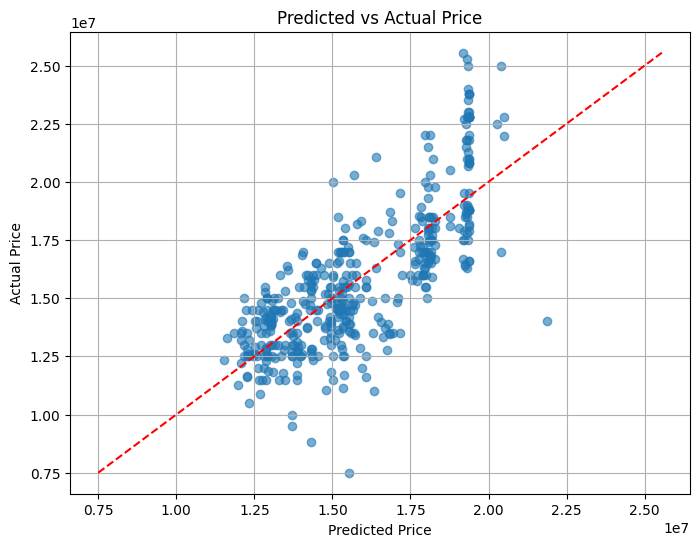

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_model['Predicted Price'], df_model['Price'], alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Predicted vs Actual Price')
plt.grid()
plt.show()


In [33]:
df_model['Residual'] = df_model['Predicted Price'] - df_model['Price']

In [34]:
def deal_type(residual):
    if residual > 1_000_000:
        return 'Underpriced'
    elif residual < -1_000_000:
        return 'Overpriced'
    else:
        return 'Fair'

df_model['Deal Type'] = df_model['Residual'].apply(deal_type)


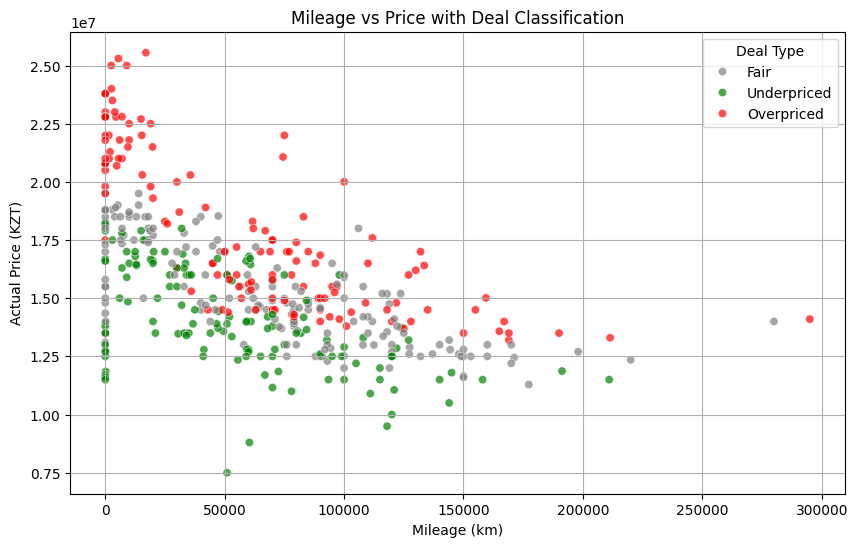

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_model,
    x='Mileage (km)', y='Price',
    hue='Deal Type',
    palette={'Underpriced': 'green', 'Overpriced': 'red', 'Fair': 'gray'},
    alpha=0.7
)

plt.title('Mileage vs Price with Deal Classification')
plt.xlabel('Mileage (km)')
plt.ylabel('Actual Price (KZT)')
plt.legend(title='Deal Type')
plt.grid(True)
plt.show()
